In [1]:
# Author: Anonymized
# License: CC-BY-NC-SA 4.0

# Import libraries

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For nicer plots
import logging
import os

/opt/homebrew/Caskroom/miniconda/base/envs/mapillary/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Define Constants and File Paths

In [3]:
notebook_dir = os.path.abspath('')
PROJECT_ROOT = os.path.dirname(notebook_dir)

# Define all directories based on the Project Root
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
FIGURES_DIR = os.path.join(RESULTS_DIR, "figures", "statistics")

# Create the directories to ensure they exist
os.makedirs(FIGURES_DIR, exist_ok=True)

CLUSTERED_NETWORK_CSV = os.path.join(RESULTS_DIR, "full_network_with_clusters.csv")
CLUSTER_PROFILES_CSV = os.path.join(RESULTS_DIR, "cluster_profiles_summary.csv")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Helper Functions

In [4]:
def cluster_profile(df_with_clusters, numerical_cols_to_profile, categorical_cols_to_profile, n_clusters_actual):
    """
    Calculates and displays a profile for each cluster.
    For numerical features: min, max, median, mean, std.
    For categorical features: mode and its proportion.
    """
    logging.info("\n--- Generating Cluster Profiles ---")
    if 'cluster' not in df_with_clusters.columns:
        logging.error("Cluster column not found in DataFrame. Cannot generate profile.")
        return pd.DataFrame()

    valid_numerical_cols = [col for col in numerical_cols_to_profile if col in df_with_clusters.columns]
    valid_categorical_cols = [col for col in categorical_cols_to_profile if col in df_with_clusters.columns]

    if not valid_numerical_cols and not valid_categorical_cols:
        logging.error("No valid numerical or categorical columns found for profiling.")
        return pd.DataFrame()

    agg_dict = {}
    profile_extras = {}

    # Prepare aggregations for numerical columns
    for col in valid_numerical_cols:
        agg_dict[col] = ['min', 'max', 'median', 'mean', 'std']

    # Prepare for categorical columns (mode and proportion calculated separately)
    mode_data = {}
    mode_proportion_data = {}
    for col in valid_categorical_cols:
        mode_series = df_with_clusters.groupby('cluster')[col].apply(lambda x: x.mode()[0] if not x.mode().empty else "N/A")
        mode_data[col] = mode_series

        def get_mode_proportion(series):
            if series.empty: return 0.0
            mode_val = series.mode()[0] if not series.mode().empty else None
            if mode_val is None: return 0.0
            return (series == mode_val).sum() / len(series) * 100
        proportion_series = df_with_clusters.groupby('cluster')[col].apply(get_mode_proportion).round(1)
        mode_proportion_data[f"{col}_mode_proportion (%)"] = proportion_series

    profile_df_num = pd.DataFrame()
    if agg_dict: # Check if agg_dict was populated (i.e., if numerical_cols existed)
        try:
            profile_df_num = df_with_clusters.groupby("cluster").agg(agg_dict)
            if isinstance(profile_df_num.columns, pd.MultiIndex):
                profile_df_num.columns = ['_'.join(col_level).strip() for col_level in profile_df_num.columns.values]
        except Exception as e_agg:
            logging.error(f"Error during numerical aggregation: {e_agg}")
            expected_num_cols = [f"{col}_{stat}" for col in valid_numerical_cols for stat in ['min', 'max', 'median', 'mean', 'std']]
            profile_df_num = pd.DataFrame(columns=expected_num_cols, index=pd.RangeIndex(n_clusters_actual))

    profile_df_cat_mode = pd.DataFrame(mode_data)
    profile_df_cat_prop = pd.DataFrame(mode_proportion_data)

    profile_df_final = pd.concat([profile_df_num, profile_df_cat_mode, profile_df_cat_prop], axis=1)

    cluster_sizes = df_with_clusters['cluster'].value_counts().sort_index()
    profile_df_final.insert(0, 'Cluster_Size', cluster_sizes)
    profile_df_final.insert(1, 'Cluster_Proportion (%)', (cluster_sizes / cluster_sizes.sum() * 100).round(2))

    # Reorder for better readability
    final_ordered_cols = ['Cluster_Size', 'Cluster_Proportion (%)']
    for col_base in valid_numerical_cols:
        for stat in ['min', 'max', 'median', 'mean', 'std']:
             if f'{col_base}_{stat}' in profile_df_final.columns: final_ordered_cols.append(f'{col_base}_{stat}')
    for col_base in valid_categorical_cols:
        if col_base in profile_df_final.columns: final_ordered_cols.append(col_base) # Mode column
        if f'{col_base}_mode_proportion (%)' in profile_df_final.columns: final_ordered_cols.append(f'{col_base}_mode_proportion (%)')

    remaining_profile_cols = [col for col in profile_df_final.columns if col not in final_ordered_cols]
    profile_df_final = profile_df_final[final_ordered_cols + remaining_profile_cols]

    logging.info("Cluster Profiles Table:")
    try:
        profile_str = profile_df_final.to_string()
        for line in profile_str.split('\n'): logging.info(line)
    except:
        print("\nCluster Profiles Table:\n", profile_df_final)

    # --- Visualizations ---
    if valid_numerical_cols:
        for num_col in valid_numerical_cols:
            plt.figure(figsize=(max(8, n_clusters_actual * 1.5), 5)) # Adjust width based on num clusters
            sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")
            plt.title(f'Distribution of {num_col} by cluster', fontsize=14)
            plt.xlabel('Cluster', fontsize=12)
            plt.ylabel(num_col, fontsize=12)
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_DIR, f"cluster_boxplot_{num_col}.png"), dpi=300)
            plt.show()


    if valid_categorical_cols:
        for cat_col in valid_categorical_cols:
            plt.figure(figsize=(max(10, n_clusters_actual * 2), 6)) # Adjust width
            # Calculate proportions for plotting
            cross_tab = pd.crosstab(df_with_clusters['cluster'], df_with_clusters[cat_col], normalize='index') * 100
            # Select top N categories for less cluttered plot if many unique values
            top_n_categories = df_with_clusters[cat_col].value_counts().nlargest(7).index
            cross_tab_filtered = cross_tab[[col for col in top_n_categories if col in cross_tab.columns]]
            if len(df_with_clusters[cat_col].unique()) > 7:
                 cross_tab_filtered['Other'] = 100 - cross_tab_filtered.sum(axis=1)


            cross_tab_filtered.plot(kind='bar', stacked=True, colormap='Spectral', ax=plt.gca())
            plt.title(f'Proportion of {cat_col} by cluster', fontsize=14)
            plt.ylabel('Percentage (%)', fontsize=12)
            plt.xlabel('Cluster', fontsize=12)
            plt.xticks(rotation=0)
            plt.legend(title=cat_col, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
            plt.savefig(os.path.join(FIGURES_DIR, f"cluster_stackedbar_{cat_col}.png"), dpi=300)
            plt.show()


    return profile_df_final

In [5]:
def extract_city_name(edge_id):
    """
    Extracts a multi-word city name from a unique_edge_id.
    Assumes the ID is formatted as 'City_Word_1_City_Word_2_..._numeric_id_...'.
    It joins all parts until the first numeric part is found.

    Examples:
    - 'San_Francisco_12345_67890_0' -> 'San Francisco'
    - 'Berlin_12345_67890_0' -> 'Berlin'
    - 'San_Jose_12345_67890_0' -> 'San Jose'
    """
    if not isinstance(edge_id, str):
        return "unknown_city"

    parts = edge_id.split('_')
    city_name_parts = []

    for part in parts:
        # Check if the part is purely numeric (e.g., '12345')
        if part.isnumeric():
            break  # Stop when we hit the first number
        city_name_parts.append(part)

    # If no non-numeric parts were found, return a default
    if not city_name_parts:
        return "unknown_city"

    # Join the collected parts with a space
    return " ".join(city_name_parts)

## Main Analysis Script Logic

INFO: Loading clustered network data from: /Anonymized/results/full_network_with_clusters.csv
INFO: Successfully loaded 7002507 edges with cluster labels.
INFO: Remapped and ordered clusters. Order: ['A', 'B', 'C', 'D']
INFO: Converted 'length' column to numeric.
INFO: Extracted 'city_id' from 'unique_edge_id'.
INFO: Unique cities found: ['accra', 'alexandria', 'algiers', 'amman', 'amsterdam', 'apia', 'auckland', 'baghdad', 'baku', 'bangkok', 'beijing', 'beirut', 'belgrade', 'berlin', 'bogota', 'boston', 'brisbane', 'brussels', 'bucharest', 'budapest', 'buenos aires', 'cairo', 'calgary', 'caracas', 'casablanca', 'chennai', 'chicago', 'city of cape town', 'ciudad de tunez', 'coimbra', 'colombo', 'dakar', 'dar es salaam', 'delhi', 'dhaka', 'distrito de panama', 'doha', 'dubai', 'dublin', 'fortaleza', 'guadalajara', 'hamburg', 'ho chi minh city', 'honiara', 'houston', 'istanbul', 'jakarta', 'kampala', 'karachi', 'kigali', 'kuala lumpur', 'kyiv', 'la paz', 'lagos', 'london', 'los angeles',

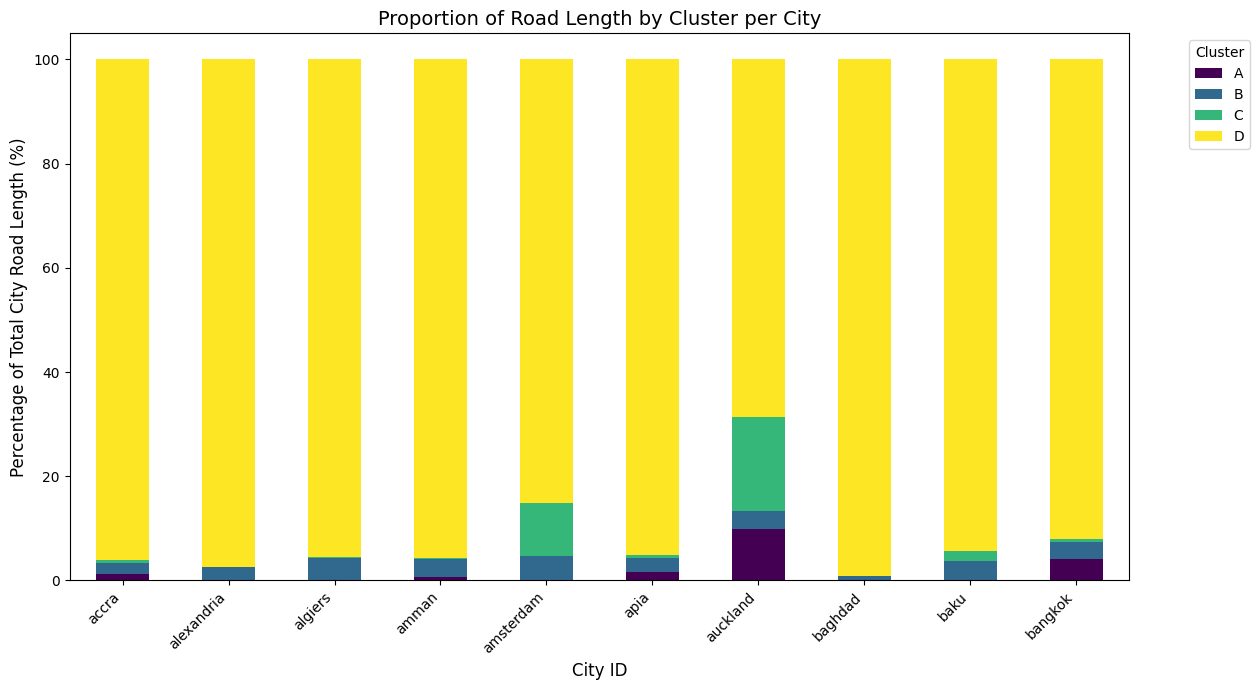

INFO: 
--- Calculating Proportions by World Bank Region ---
INFO: Mapped cities to World Bank regions using robust matching.
INFO: Regions found in data: ['East Asia and Pacific', 'Europe and Central Asia', 'Latin America and The Caribbean', 'Middle East and North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa']
INFO: Proportion of Road Length by Cluster per World Bank Region (%):
INFO: cluster                              A      B      C      D
INFO: region                                                     
INFO: East Asia and Pacific             3.34   4.63  10.45  81.59
INFO: Europe and Central Asia          12.58   4.05  13.51  69.86
INFO: Latin America and The Caribbean   4.29   5.26   5.18  85.27
INFO: Middle East and North Africa      1.39   5.08   0.84  92.69
INFO: North America                     2.73  11.58  33.50  52.19
INFO: South Asia                        0.04   1.86   0.33  97.77
INFO: Sub-Saharan Africa                0.42   1.01   2.11  96.45
INFO: Reg

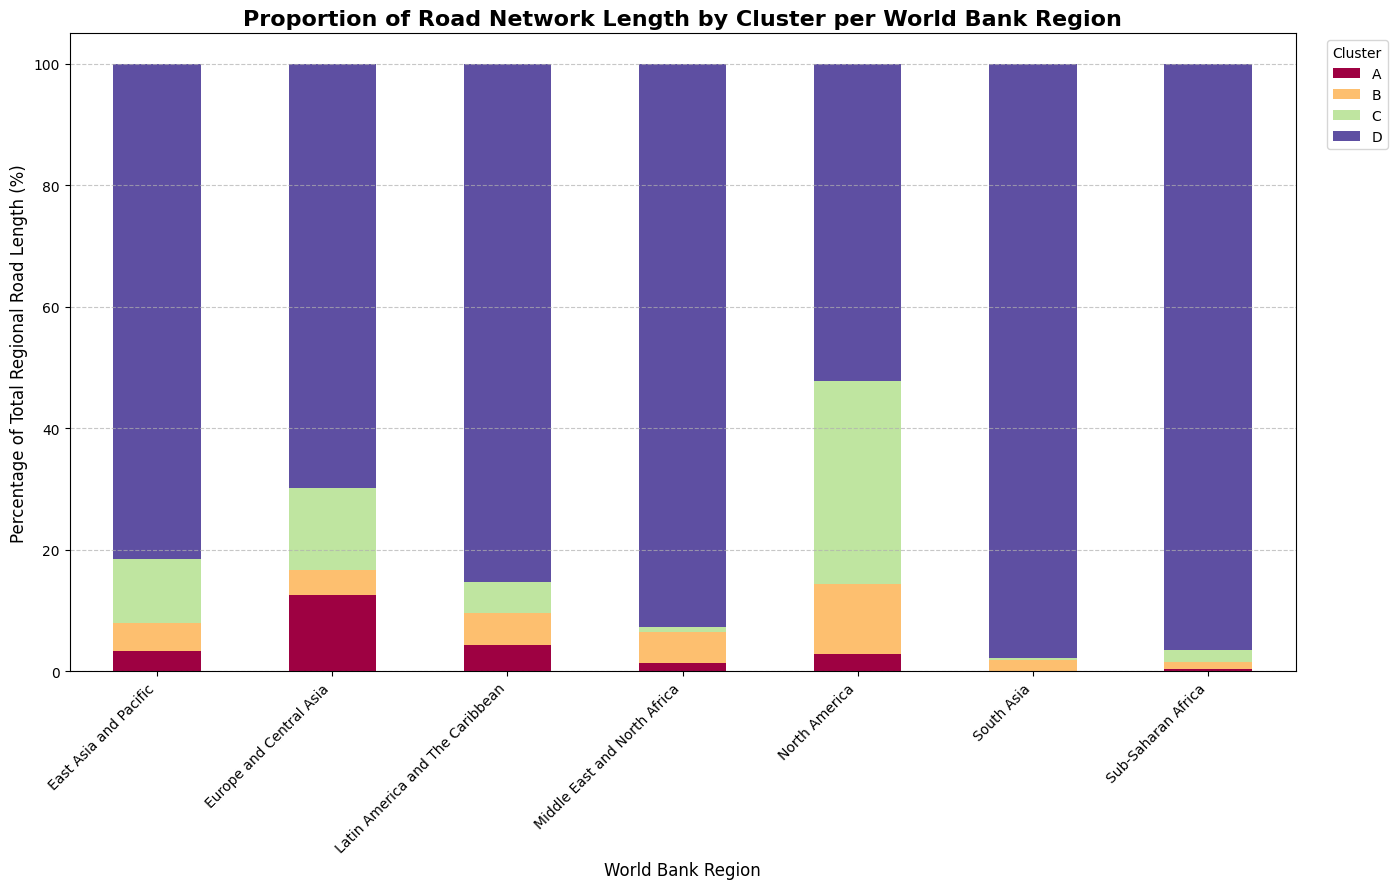

INFO: 
--- Generating Cluster Profiles ---
INFO: Cluster Profiles Table:
INFO:          Cluster_Size  Cluster_Proportion (%)  traffic_sign_count_min  traffic_sign_count_max  traffic_sign_count_median  traffic_sign_count_mean  traffic_sign_count_std  highway_traffic_signals_count_min  highway_traffic_signals_count_max  highway_traffic_signals_count_median  highway_traffic_signals_count_mean  highway_traffic_signals_count_std  TotalCrossingCount_min  TotalCrossingCount_max  TotalCrossingCount_median  TotalCrossingCount_mean  TotalCrossingCount_std  lanes_min  lanes_max  lanes_median  lanes_mean  lanes_std  crossing_traffic_signals_count_min  crossing_traffic_signals_count_max  crossing_traffic_signals_count_median  crossing_traffic_signals_count_mean  crossing_traffic_signals_count_std  crossing_unmarked_count_min  crossing_unmarked_count_max  crossing_unmarked_count_median  crossing_unmarked_count_mean  crossing_unmarked_count_std  crossing_uncontrolled_count_min  crossing_uncontrolled_

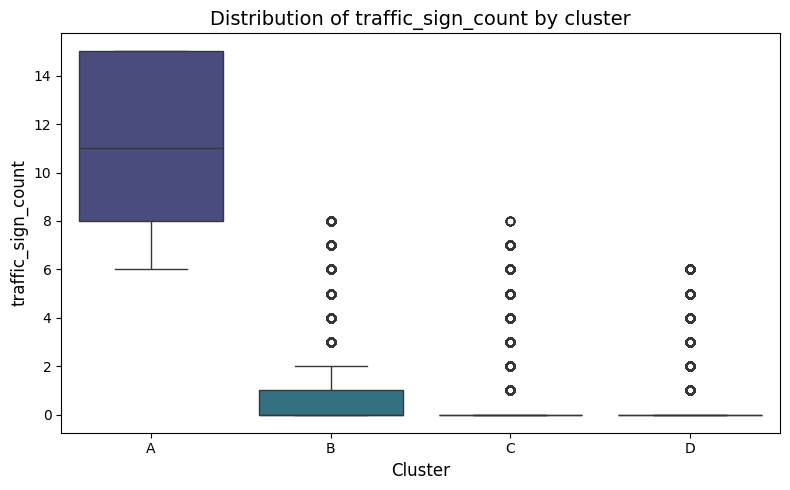

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")


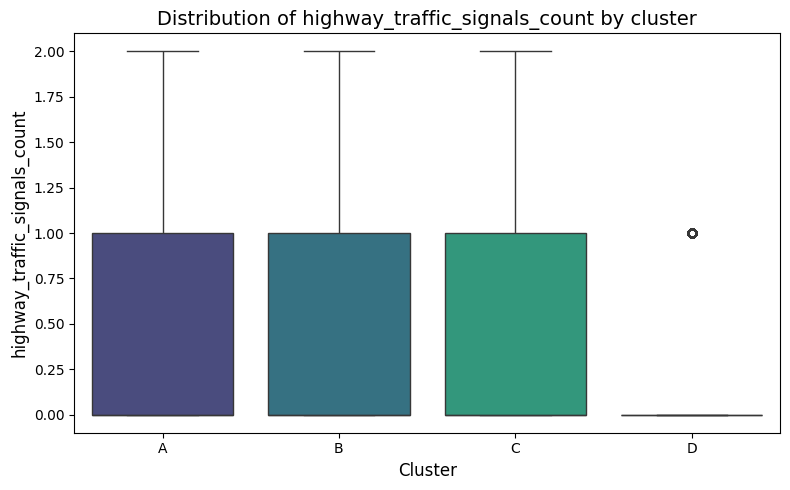

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")


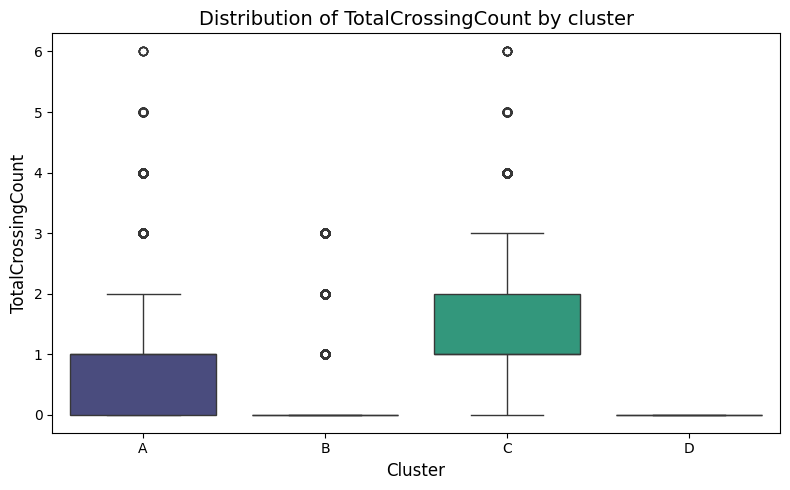

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")


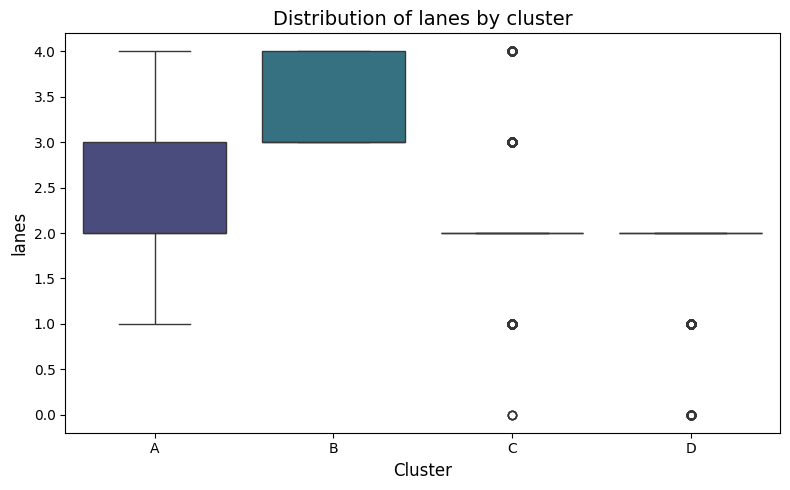

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")


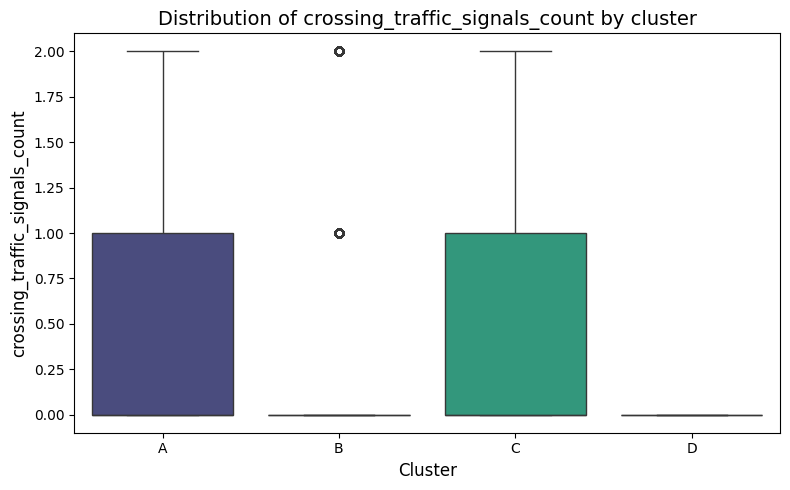

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")


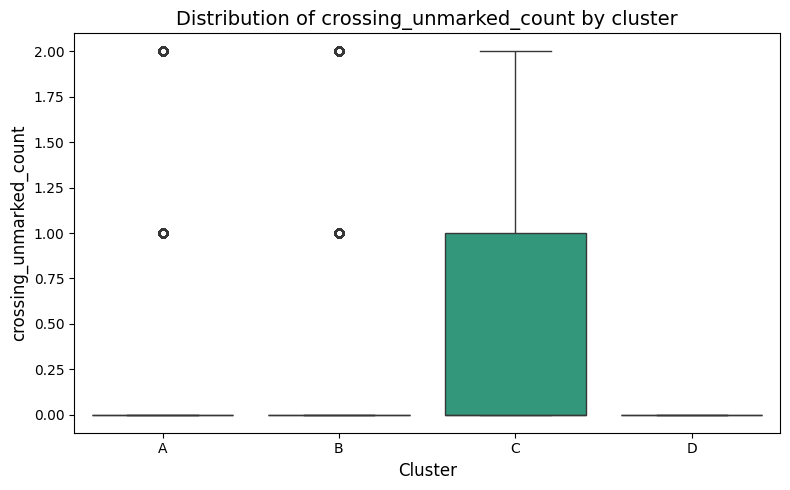

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=num_col, data=df_with_clusters, palette="viridis")


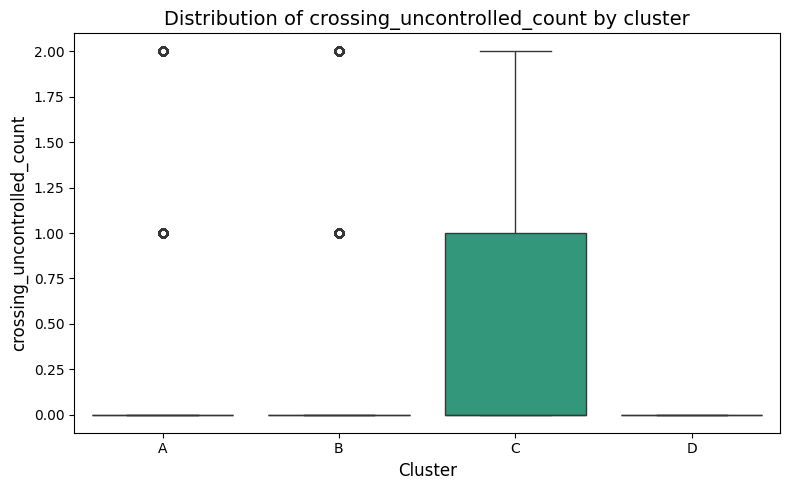

/var/folders/cy/xhpd50cx2bl_xhx8g41lvcrh0000gn/T/ipykernel_66252/451251309.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_tab_filtered['Other'] = 100 - cross_tab_filtered.sum(axis=1)


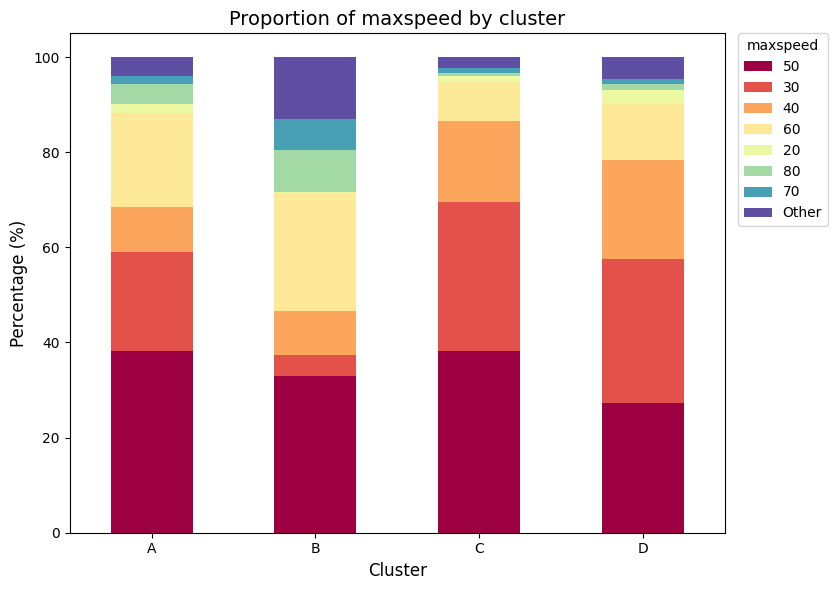

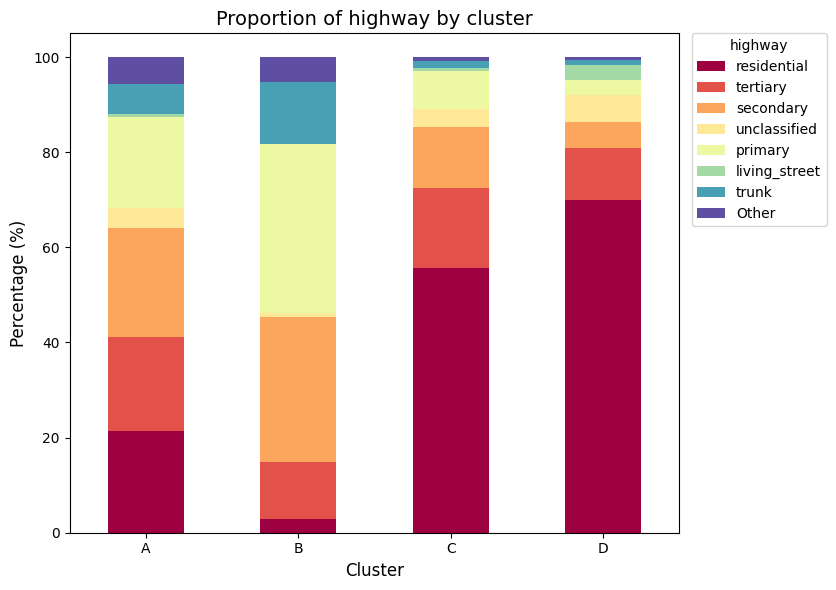

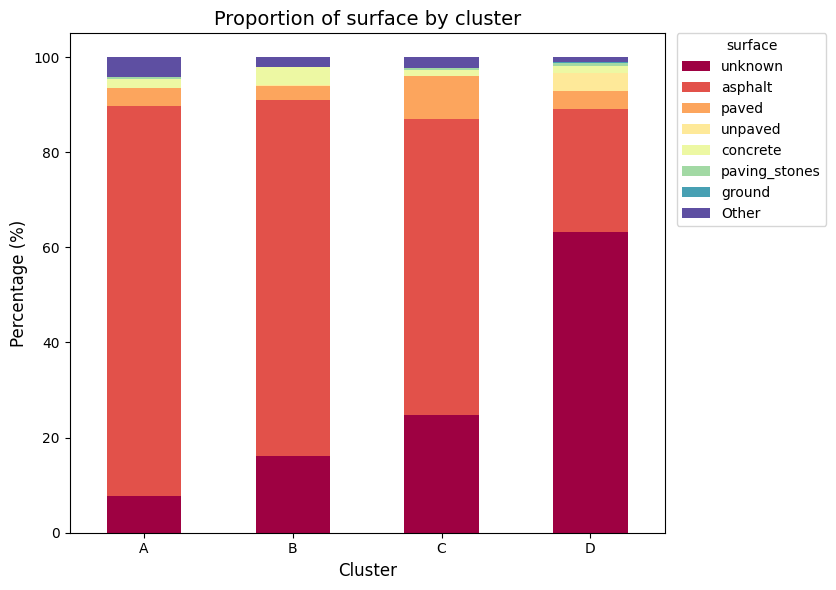

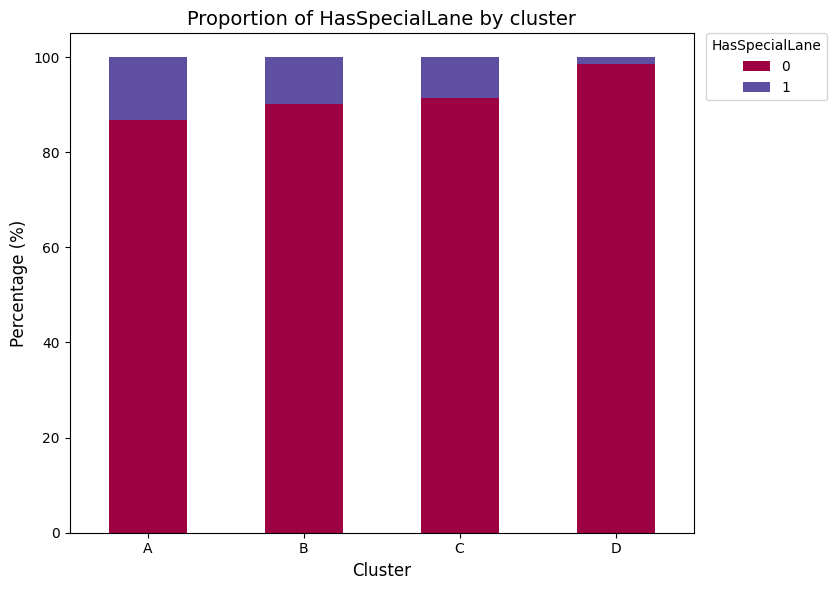

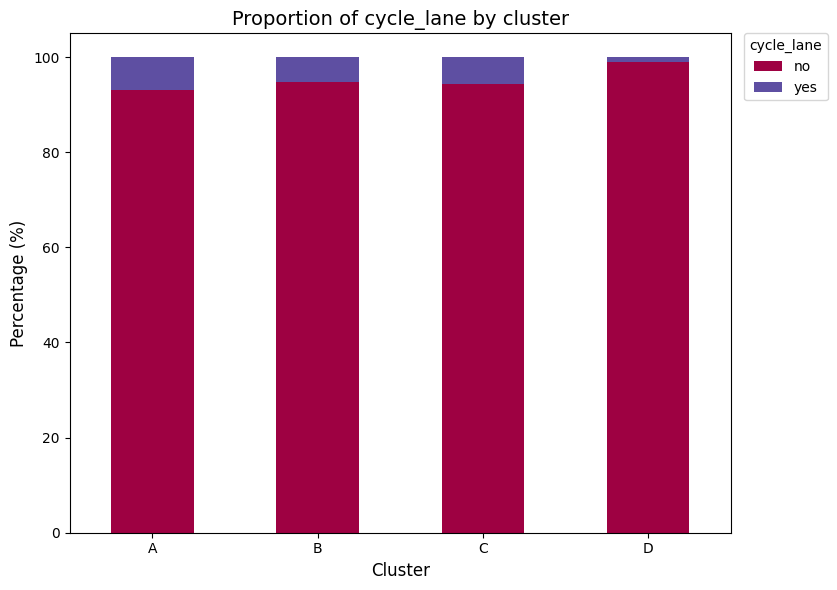

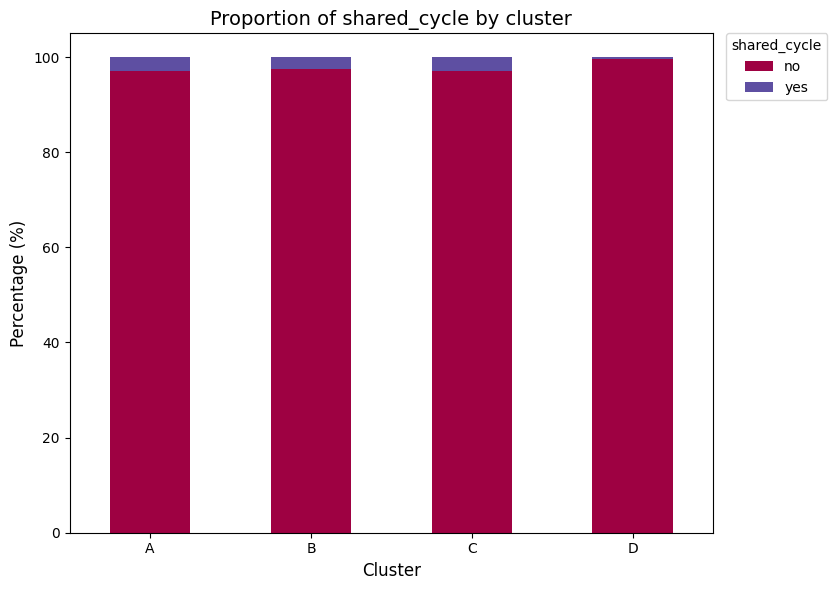

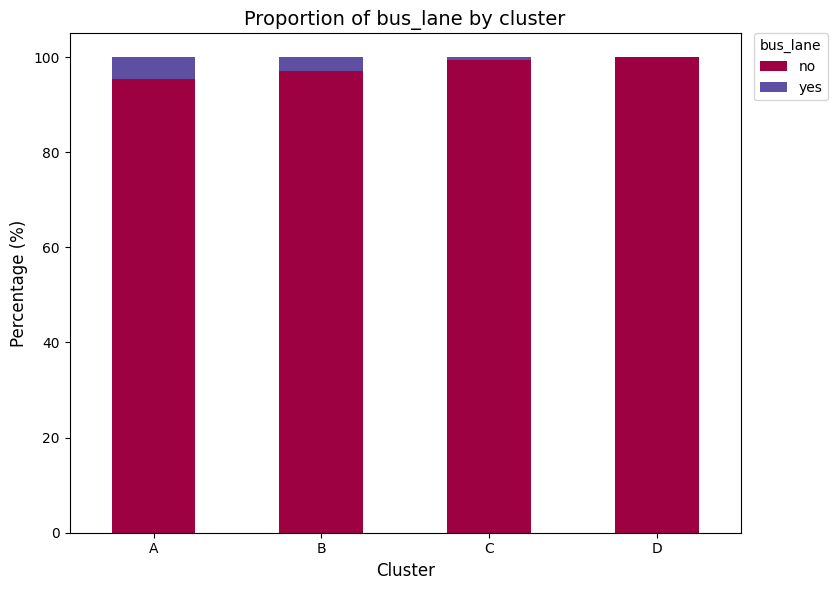

INFO: Cluster profiles summary saved to: /Anonymized/results/cluster_profiles_summary.csv
INFO: Cluster profile analysis complete.


In [6]:
if __name__ == "__main__":
    logging.info(f"Loading clustered network data from: {CLUSTERED_NETWORK_CSV}")
    try:
        dtypes_spec = {
            'lenght': float, 'lanes': float, 'maxspeed': str, 'highway': str, 'surface': str,
            'cycle_lane': str, 'shared_cycle': str, 'bus_lane': str, 'HasSpecialLane': int,
            'unique_edge_id': str, 'crossing_uncontrolled_count': int, 'crossing_unmarked_count': int,
            'crossing_traffic_signals_count': int, 'highway_traffic_signals_count': int,
            'highway_stop_count': int, 'highway_give_way_count': int, 'traffic_sign_count': int,
            'TotalCrossingCount': int, 'cluster': int
        }
        gdf_clustered_network = pd.read_csv(CLUSTERED_NETWORK_CSV, sep=';', dtype=dtypes_spec)
        logging.info(f"Successfully loaded {len(gdf_clustered_network)} edges with cluster labels.")

        if 'cluster' in gdf_clustered_network.columns:
            cluster_mapping = {0: 'A', 1: 'D', 2: 'B', 3: 'C'}
            gdf_clustered_network['cluster'] = gdf_clustered_network['cluster'].replace(cluster_mapping)
            
            desired_order = ['A', 'B', 'C', 'D']
            gdf_clustered_network['cluster'] = pd.Categorical(
                gdf_clustered_network['cluster'], categories=desired_order, ordered=True
            )
            logging.info(f"Remapped and ordered clusters. Order: {desired_order}")

        # --- Data Cleaning and Preparation for City-Level Stats ---
        if 'length' in gdf_clustered_network.columns:
            if gdf_clustered_network['length'].dtype == 'object':
                gdf_clustered_network['length'] = gdf_clustered_network['length'].str.replace(',', '.').astype(float)
            gdf_clustered_network['length'] = pd.to_numeric(gdf_clustered_network['length'], errors='coerce')
            gdf_clustered_network.dropna(subset=['length'], inplace=True)
            logging.info("Converted 'length' column to numeric.")
        else:
            logging.error("'length' column not found. Cannot calculate length-based proportions.")

        # --- MODIFIED SECTION: Extract 'city_id' from 'unique_edge_id' ---
        if 'unique_edge_id' in gdf_clustered_network.columns:
            try:
                # Use the new robust function instead of the simple split
                gdf_clustered_network['city_id'] = gdf_clustered_network['unique_edge_id'].apply(extract_city_name)
                logging.info("Extracted 'city_id' from 'unique_edge_id'.")
                # Add a verification step to see the result
                logging.info(f"Unique cities found: {sorted(gdf_clustered_network['city_id'].unique())}")
            except Exception as e_city_extract:
                logging.error(f"Could not extract city_id from unique_edge_id: {e_city_extract}. City-level stats will be affected.")
                gdf_clustered_network['city_id'] = "unknown_city"
        else:
            logging.error("'unique_edge_id' column not found. Cannot extract 'city_id' for city-level stats.")
        # --- END MODIFIED SECTION ---

        if 'cluster' not in gdf_clustered_network.columns:
            logging.error("The loaded CSV file does not contain a 'cluster' column.")
        elif 'length' not in gdf_clustered_network.columns or 'city_id' not in gdf_clustered_network.columns:
             logging.error("Required columns ('length', 'city_id') not available for city-level cluster proportions.")
        else:
            # --- START: Calculate Proportion of Road Length in Each Cluster per City ---
            logging.info("\n--- Calculating Proportion of Road Length in Each Cluster per City ---")

            total_length_per_city = gdf_clustered_network.groupby('city_id')['length'].sum()
            length_per_cluster_city = gdf_clustered_network.groupby(['city_id', 'cluster'])['length'].sum()

            length_per_cluster_city_df = length_per_cluster_city.reset_index()
            merged_df = pd.merge(length_per_cluster_city_df,
                                 total_length_per_city.rename('total_city_length'),
                                 on='city_id',
                                 how='left')
            merged_df['proportion_length_in_cluster (%)'] = \
                (merged_df['length'] / merged_df['total_city_length'] * 100).round(2)

            try:
                proportion_table_length = merged_df.pivot_table(
                    index='city_id',
                    columns='cluster',
                    values='proportion_length_in_cluster (%)',
                    fill_value=0
                ).sort_index() # sort_index() will now correctly sort by city name
                
                existing_cols_in_order = [col for col in ['A', 'B', 'C', 'D'] if col in proportion_table_length.columns]
                proportion_table_length = proportion_table_length[existing_cols_in_order]

                logging.info("Proportion of Road Length by Cluster per City (%):")
                profile_str_len = proportion_table_length.to_string()
                for line in profile_str_len.split('\n'): logging.info(line)

                output_csv_path = os.path.join(RESULTS_DIR, "city_cluster_length_proportions.csv")
                proportion_table_length.to_csv(output_csv_path, sep=";")
                logging.info(f"City cluster length proportions saved to {output_csv_path}")
                
                if len(proportion_table_length) > 0:
                    cities_to_plot = proportion_table_length.index[:min(10, len(proportion_table_length))]
                    proportion_table_length.loc[cities_to_plot].plot(
                        kind='bar',
                        stacked=True,
                        figsize=(15, 7),
                        colormap='viridis'
                    ).legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.title('Proportion of Road Length by Cluster per City', fontsize=14)
                    plt.ylabel('Percentage of Total City Road Length (%)', fontsize=12)
                    plt.xlabel('City ID', fontsize=12)
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout(rect=[0, 0, 0.85, 1])
                    plt.savefig(os.path.join(FIGURES_DIR, "city_cluster_length_proportions_plot.png"), dpi=300)
                    plt.show()

            except Exception as e_pivot:
                logging.error(f"Error creating or plotting proportion table for length: {e_pivot}")
                logging.info("Length per cluster per city (unpivoted):\n" + merged_df.to_string())

            # --- START: World Bank Region Analysis (Robust Version) ---
            logging.info("\n--- Calculating Proportions by World Bank Region ---")

            # 1. Define a mapping from the "core" lowercase city name to the World Bank Region.
            # This is designed to work with the messy, lowercase city_ids from your data.
            # For example, the key 'cape town' will match the city_id 'city of cape town'.
            core_city_to_region_map = {
                # East Asia and Pacific
                'kuala lumpur': 'East Asia and Pacific', 'singapore': 'East Asia and Pacific',
                'jakarta': 'East Asia and Pacific', 'tokyo': 'East Asia and Pacific',
                'melbourne': 'East Asia and Pacific', 'manila': 'East Asia and Pacific',
                'bangkok': 'East Asia and Pacific', 'sydney': 'East Asia and Pacific',
                'national capital district': 'East Asia and Pacific', # for Port Moresby
                'ho chi minh city': 'East Asia and Pacific',
                'apia': 'East Asia and Pacific', 'suva': 'East Asia and Pacific',
                'honiara': 'East Asia and Pacific', 'yangon': 'East Asia and Pacific',
                'shanghai': 'East Asia and Pacific', 'beijing': 'East Asia and Pacific',
                'nukualofa': 'East Asia and Pacific', # for Nuku'alofa
                'auckland': 'East Asia and Pacific', 'wellington': 'East Asia and Pacific',
                'perth': 'East Asia and Pacific', 'brisbane': 'East Asia and Pacific',

                # Europe and Central Asia
                'moscow': 'Europe and Central Asia', 'kyiv': 'Europe and Central Asia',
                'berlin': 'Europe and Central Asia', 'brussels': 'Europe and Central Asia',
                'warsaw': 'Europe and Central Asia', 'vienna': 'Europe and Central Asia',
                'zurich': 'Europe and Central Asia', 'hamburg': 'Europe and Central Asia',
                'belgrade': 'Europe and Central Asia', 'paris': 'Europe and Central Asia',
                'bucharest': 'Europe and Central Asia', 'prague': 'Europe and Central Asia',
                'sofia': 'Europe and Central Asia', 'coimbra': 'Europe and Central Asia',
                'madrid': 'Europe and Central Asia', 'dublin': 'Europe and Central Asia',
                'istanbul': 'Europe and Central Asia', 'london': 'Europe and Central Asia',
                'rome': 'Europe and Central Asia', 'oslo': 'Europe and Central Asia',
                'reykjavik': 'Europe and Central Asia', 'tashkent': 'Europe and Central Asia',
                'baku': 'Europe and Central Asia', 'budapest': 'Europe and Central Asia',
                'amsterdam': 'Europe and Central Asia',

                # Latin America and The Caribbean
                'sao paulo': 'Latin America and The Caribbean', 'mexico city': 'Latin America and The Caribbean',
                'bogota': 'Latin America and The Caribbean', 'buenos aires': 'Latin America and The Caribbean',
                'quito': 'Latin America and The Caribbean', 'fortaleza': 'Latin America and The Caribbean',
                'montevideo': 'Latin America and The Caribbean', 'lima': 'Latin America and The Caribbean',
                'santiago': 'Latin America and The Caribbean', 'la paz': 'Latin America and The Caribbean',
                'san jose': 'Latin America and The Caribbean', 'caracas': 'Latin America and The Caribbean',
                'medellin': 'Latin America and The Caribbean', 'monterrey': 'Latin America and The Caribbean',
                'guadalajara': 'Latin America and The Caribbean', 'panama': 'Latin America and The Caribbean', # for 'distrito de panama'

                # Middle East and North Africa
                'dubai': 'Middle East and North Africa', 'tehran': 'Middle East and North Africa',
                'amman': 'Middle East and North Africa', 'casablanca': 'Middle East and North Africa',
                'riyadh': 'Middle East and North Africa', # for 'riyadh governorate'
                'tunez': 'Middle East and North Africa', # for 'ciudad de tunez' (Tunis)
                'cairo': 'Middle East and North Africa', 'beirut': 'Middle East and North Africa',
                'doha': 'Middle East and North Africa', 'algiers': 'Middle East and North Africa',
                'alexandria': 'Middle East and North Africa', 'baghdad': 'Middle East and North Africa',

                # North America
                'montreal': 'North America', 'san francisco': 'North America',
                'calgary': 'North America', 'houston': 'North America',
                'boston': 'North America', 'chicago': 'North America',
                'new york': 'North America', 'miami': 'North America',
                'toronto': 'North America', 'los angeles': 'North America',
                'vancouver': 'North America',

                # South Asia
                'mumbai': 'South Asia', 'colombo': 'South Asia',
                'karachi': 'South Asia', 'chennai': 'South Asia',
                'delhi': 'South Asia', 'dhaka': 'South Asia',

                # Sub-Saharan Africa
                'cape town': 'Sub-Saharan Africa', 'accra': 'Sub-Saharan Africa',
                'dakar': 'Sub-Saharan Africa', 'nairobi': 'Sub-Saharan Africa',
                'dar es salaam': 'Sub-Saharan Africa', 'kampala': 'Sub-Saharan Africa',
                'lagos': 'Sub-Saharan Africa', 'lusaka': 'Sub-Saharan Africa',
                'kigali': 'Sub-Saharan Africa'
            }

            # 2. Create a function to perform the robust mapping
            def find_region_for_city(city_id, region_map):
                """Checks if any of the core city names in the map exist within the city_id string."""
                for core_city, region in region_map.items():
                    if core_city in city_id:
                        return region
                return 'Other/Unknown' # Fallback if no match is found

            # 3. Apply the mapping function to create the 'region' column
            if 'city_id' in gdf_clustered_network.columns:
                gdf_clustered_network['region'] = gdf_clustered_network['city_id'].apply(
                    lambda city_id: find_region_for_city(city_id, core_city_to_region_map)
                )
                logging.info("Mapped cities to World Bank regions using robust matching.")
                unmapped_cities = gdf_clustered_network[gdf_clustered_network['region'] == 'Other/Unknown']['city_id'].unique()
                if len(unmapped_cities) > 0:
                    logging.warning(f"Could not map the following cities to a region: {list(unmapped_cities)}")
                
                logging.info(f"Regions found in data: {sorted(gdf_clustered_network['region'].unique())}")

                # 4. Group by region and cluster to get total length
                length_by_region_cluster = gdf_clustered_network.groupby(['region', 'cluster'])['length'].sum()

                # 5. Calculate proportions
                total_length_by_region = gdf_clustered_network.groupby('region')['length'].sum()
                proportion_by_region = (length_by_region_cluster / total_length_by_region * 100).unstack(level='cluster').fillna(0)
                
                desired_cluster_order = ['A', 'B', 'C', 'D']
                proportion_by_region = proportion_by_region.reindex(columns=desired_cluster_order, fill_value=0).round(2)
                
                if 'Other/Unknown' in proportion_by_region.index:
                    if proportion_by_region.loc['Other/Unknown'].sum() < 0.01:
                        proportion_by_region = proportion_by_region.drop('Other/Unknown')

                logging.info("Proportion of Road Length by Cluster per World Bank Region (%):")
                region_table_str = proportion_by_region.to_string()
                for line in region_table_str.split('\n'): logging.info(line)

                output_csv_path_region = os.path.join(RESULTS_DIR, "region_cluster_length_proportions.csv")
                proportion_by_region.to_csv(output_csv_path_region, sep=";")
                logging.info(f"Regional cluster length proportions saved to {output_csv_path_region}")

                # 6. Visualize the results
                if not proportion_by_region.empty:
                    proportion_by_region.plot(
                        kind='bar',
                        stacked=True,
                        figsize=(16, 9),
                        colormap='Spectral'
                    ).legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')

                    plt.title('Proportion of Road Network Length by Cluster per World Bank Region', fontsize=16, weight='bold')
                    plt.ylabel('Percentage of Total Regional Road Length (%)', fontsize=12)
                    plt.xlabel('World Bank Region', fontsize=12)
                    plt.xticks(rotation=45, ha='right')
                    plt.grid(axis='y', linestyle='--', alpha=0.7)
                    plt.tight_layout(rect=[0, 0, 0.88, 1])
                    output_plot_path = os.path.join(FIGURES_DIR, "region_cluster_length_proportions_plot.png")
                    plt.savefig(output_plot_path, dpi=300)
                    plt.show()

            else:
                logging.warning("Cannot perform regional analysis because 'city_id' column is missing.")
            
            # --- END: World Bank Region Analysis ---
            
            # --- Generate and display/save the overall cluster profile ---
            numerical_features_to_profile = ['traffic_sign_count', 'highway_traffic_signals_count', 'TotalCrossingCount', 'lanes']
            categorical_features_to_profile = ['maxspeed', 'highway', 'surface', 'HasSpecialLane']
            original_crossing_counts = ['crossing_traffic_signals_count', 'crossing_unmarked_count', 'crossing_uncontrolled_count']
            for col in original_crossing_counts:
                if col in gdf_clustered_network.columns and col not in numerical_features_to_profile: numerical_features_to_profile.append(col)
            original_lane_features = ['cycle_lane', 'shared_cycle', 'bus_lane']
            for col in original_lane_features:
                if col in gdf_clustered_network.columns and col not in categorical_features_to_profile: categorical_features_to_profile.append(col)

            actual_n_clusters = gdf_clustered_network['cluster'].nunique()
            
            profile_table = cluster_profile(gdf_clustered_network, numerical_features_to_profile, categorical_features_to_profile, actual_n_clusters)
            if not profile_table.empty:
                try:
                    output_profile_path = os.path.join(RESULTS_DIR, CLUSTER_PROFILES_CSV)
                    profile_table.to_csv(output_profile_path, sep=";")
                    logging.info(f"Cluster profiles summary saved to: {output_profile_path}")
                except Exception as e_save_profile: logging.error(f"Could not save cluster profiles CSV: {e_save_profile}")

            logging.info("Cluster profile analysis complete.")

    except FileNotFoundError:
        logging.error(f"Clustered network file not found: {CLUSTERED_NETWORK_CSV}. Please run the main script with clustering first.")
    except Exception as e:
        logging.error(f"An error occurred during file analysis: {e}", exc_info=True)